In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn.functional as F
import torchvision.transforms.functional as FT

In [3]:
## Import from drive
import gdown

url = "https://drive.google.com/uc?id=16FK1YnHPhGqCHf_EpovzcH0v90yXcCer"

output = 'artDL.zip'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16FK1YnHPhGqCHf_EpovzcH0v90yXcCer
To: /content/artDL.zip
100%|██████████| 3.62G/3.62G [00:58<00:00, 61.6MB/s]


'artDL.zip'

In [4]:
!unzip -q /content/artDL.zip

In [9]:
info_df = pd.read_csv('/content/DEVKitArt/info.csv')

In [10]:
train_set, test_set, val_set = info_df[info_df['set'] == 'train'], info_df[info_df['set'] == 'val'], info_df[info_df['set'] == 'test']

In [ ]:
test_set

,item,11F(MARY),11H(ANTONY ABBOT),11H(ANTONY OF PADUA),11H(AUGUSTINE),11H(DOMINIC),11H(FRANCIS),11H(JEROME),11H(JOHN THE BAPTIST),11H(JOHN),11H(JOSEPH),11H(PAUL),11H(PETER),11H(SEBASTIAN),11H(STEPHEN),11HH(BARBARA),11HH(CATHERINE),11HH(MARY MAGDALENE),John Baptist - Child,John Baptist - Dead,set
1,0007c0a4-31fe-4a8c-b23f-ee79528c96cb_970b7762-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,val
18,032ed98d-94e2-4c4c-9d1e-b775d2bf0610_7e3988c4-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,val
33,0806d39a-48fb-4d78-9761-178a1b235636_642b6845-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,val
43,093cbda0-b9c4-445e-b6d3-56c423811f46_2e06bb9c-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,val
60,0e47ce9f-8af5-4f28-8016-4228189e1a3a_44573a91-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42141,tiziano_06_1560s_09magdal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,val
42224,vaccar_martyrd2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,val
42325,viola_magdalen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,val
42337,vivarini_alvise_mary_mag,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,val


In [5]:
import os
import cv2
import torch
from PIL import Image
class ArtDLDataset(Dataset):
  def __init__(self, data_dir = None, transform = None, labels_path = None, set_type = 'train'):
    self.data_dir = data_dir
    self.transform = transform
    self.labels_path = labels_path
    labels_df = pd.read_csv(self.labels_path)
    self.labels_df = labels_df[labels_df['set'] == set_type]
    self.img_names = list(self.labels_df['item'])

  def __getitem__(self, idx):
    filename = self.img_names[idx]
    #print(filename)
    image = Image.open(self.data_dir + "/" + filename + ".jpg")
    if(self.transform!=None):
      image = self.transform(image)
    

    image_label = self.labels_df[self.labels_df['item'] == filename].values.squeeze()[2:20].argmax()
    #print(image_label)
    
    return (image, image_label)

  def __len__(self):
    return len(self.img_names)

In [6]:
import torchvision.transforms as transforms
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return FT.pad(image, padding, 0, 'constant')

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize((224,224)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(p=0.5)
])


val_transform = transforms.Compose([
	  SquarePad(),
		transforms.Resize((224,224)),
	  transforms.CenterCrop((224,224)),
		transforms.ToTensor()
])

In [7]:
train_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'train'
)

In [8]:
test_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = val_transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'test'
)

In [9]:
val_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = val_transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'val'
)

In [ ]:
test_dataset[1][0].shape

torch.Size([3, 224, 224])

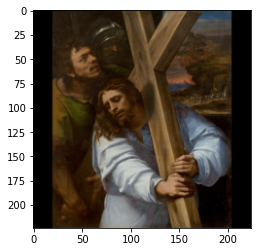

In [10]:
import matplotlib.pyplot as plt
plt.imshow(test_dataset[1][0].permute(1,2,0).numpy())

In [11]:
from collections import Counter

In [ ]:
import numpy as np 

y_train_indices = range(len(train_dataset))

y_train = [train_dataset[i][1] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

In [ ]:
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

In [ ]:
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [13]:
train_loader = DataLoader(dataset = train_dataset, shuffle=True, batch_size = 50)
test_loader = DataLoader(dataset = test_dataset, batch_size = 10)
val_loader = DataLoader(dataset = val_dataset, batch_size = 10)

In [14]:
import torchvision.models as models
import torch.nn as nn

In [ ]:
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

In [ ]:
image, label = next(iter(train_loader))

In [15]:
class ArtDLClassifier(nn.Module):
  def __init__(self, num_classes):
    super(ArtDLClassifier, self).__init__()
    self.resnet = models.resnet50(pretrained=True)
    self.net = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
    self.fc_conv = nn.Conv2d(in_channels = 2048, out_channels = num_classes, kernel_size=1)
    self.tr_params = nn.ModuleList([self.net[4][2:], self.net[5], self.net[6], self.net[7], self.fc_conv])
  def forward(self, image):
    out = self.net(image)
    out = self.fc_conv(out)
    return out

  def trainable_params(self):
    return (list(self.tr_params.parameters()))

In [ ]:
out = clf(image.to(device))
out = F.softmax(out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
out.squeeze().shape

torch.Size([50, 19])

In [ ]:
clf.zero_grad()

In [ ]:
ma.shape

torch.Size([19, 1, 1])

In [ ]:
ma, argm = out.max(dim = 0)

In [ ]:
ma = ma.cpu()

In [ ]:
argm = argm.cpu()

In [17]:
import torch.optim as optim

In [18]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [19]:
clf = ArtDLClassifier(num_classes = 19).to(device)
optimizer = optim.SGD(clf.trainable_params(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [20]:
def train(epochs, model, train_loader, val_loader, optimizer, device, criterion):
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0
    for idx, (image, label) in enumerate(train_loader):
      image = image.to(device)
      #print(image.shape)
      label = label.to(device)
      optimizer.zero_grad()
      outputs = model(image).squeeze()
      loss = criterion(outputs, label)
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
    
    with torch.no_grad():
      model.eval()
      val_score = 0
      for idx, (image, label) in enumerate(val_loader):
        image = image.to(device)
        label = label.to(device)
        outputs = model(image).squeeze()
        pred = outputs.argmax(dim = 1, keepdim = True)
        val_score += pred.eq(label.view_as(pred)).sum().item()
        loss = criterion(outputs, label)
        val_loss += loss.item()
    
    print("=================================================")
    print("Epoch: {}".format(epoch+1))
    print("Validation Loss: {}".format(val_loss/len(val_loader)))
    print("Training Loss: {}".format(train_loss/len(train_loader)))
    print(val_score)
    print("Validation Accuracy: {}".format((val_score)/len(val_loader)*10))

In [ ]:
train(10, clf, train_loader, val_loader, optimizer, device, criterion)

Epoch: 1
Validation Loss: 1.4981446406947305
Training Loss: 1.5551484658529884
2495
Validation Accuracy: 59.97596153846154
Epoch: 2
Validation Loss: 1.4503457255733128
Training Loss: 1.300830365185849
2553
Validation Accuracy: 61.37019230769231
Epoch: 3
Validation Loss: 1.4564640136578908
Training Loss: 1.1625126084389046
2588
Validation Accuracy: 62.21153846153846
Epoch: 4
Validation Loss: 1.4298449412274818
Training Loss: 1.0537854972028593
2525
Validation Accuracy: 60.69711538461539
Epoch: 5
Validation Loss: 1.3548670298634813
Training Loss: 0.9532510594230647
2658
Validation Accuracy: 63.89423076923077
Epoch: 6
Validation Loss: 1.4851956412626
Training Loss: 0.8596800345687838
2559
Validation Accuracy: 61.51442307692307
Epoch: 7
Validation Loss: 1.5237395154097333
Training Loss: 0.766993318058071
2504
Validation Accuracy: 60.19230769230769
Epoch: 8
Validation Loss: 1.923497857651315
Training Loss: 0.6773440230920998
2271
Validation Accuracy: 54.591346153846146
